In [2]:
# set up paths to relevant directories
ROOT <- rprojroot::find_rstudio_root_file()
SRC_PATH <- paste0(ROOT, "/source_code/R/")

setwd(SRC_PATH)

# turn off warnings caused by package versioning
options(warn = -1)

# load libraries and functions
source("get_data.R")
library(ggplot2)
library(data.table) # used for faster performance on large data sets
library(dtplyr)     # used for faster performance on large data sets
library(dplyr)
library(stringr)

# turn warnings back on for safety
options(warn = 0)

# set default output plot size
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)

In [4]:
df_ratings <- get_movielens_large()

Rows: 25000095 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): userId, movieId, rating, timestamp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 62423 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): title, genres
dbl (1): movieId

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
df_ratings %>% head(10)

userId,movieId,title,rating
<dbl>,<dbl>,<chr>,<dbl>
1,296,Pulp Fiction (1994),5.0
1,306,Three Colors: Red (Trois couleurs: Rouge) (1994),3.5
1,307,Three Colors: Blue (Trois couleurs: Bleu) (1993),5.0
1,665,Underground (1995),5.0
1,899,Singin' in the Rain (1952),3.5
1,1088,Dirty Dancing (1987),4.0
1,1175,Delicatessen (1991),3.5
1,1217,Ran (1985),3.5
1,1237,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",5.0


In [10]:
df_ratings %>% dim()

[1] 25000095        4

# EDA

## Number of Ratings

In [11]:
df_ratings %>% 
  lazy_dt() %>% # coerce to lazy_dt() to use dtplyr
  group_by(title) %>% 
  summarise(
    num_of_ratings = n(),
    avg_rating = mean(rating, na.rm = T)
  ) %>% 
  arrange(desc(num_of_ratings)) %>% 
  head(20) %>% 
  as_tibble() # reformat back as tibble for readability

title,num_of_ratings,avg_rating
<chr>,<int>,<dbl>
Forrest Gump (1994),81491,4.048011
"Shawshank Redemption, The (1994)",81482,4.413576
Pulp Fiction (1994),79672,4.188912
"Silence of the Lambs, The (1991)",74127,4.151342
"Matrix, The (1999)",72674,4.154099
Star Wars: Episode IV - A New Hope (1977),68717,4.120189
Jurassic Park (1993),64144,3.679175
Schindler's List (1993),60411,4.247579
Braveheart (1995),59184,4.002273


Forrest Gump, Shawshank Redemption, and Pulp Fiction are the most rated movies. Interestingly, all 3 moveis came out in 1994. In fact:

* 13 of the 20 most rated movies were all released in the 90's. 
* Of the 6 movies not released in the 90's, 3 of them were George Lucas films: New Hope, Empire Strikes Back, and Indiana Jones. 
* Lord of the Rings 1 and 2 both appear and represent the only movies from the 2000's.
* Rounding out the top 20 is The Godfather.

Cursory inspection shows that the movies with a large number of ratings are all generally regarded as masterpiece films.

* Forrest Gump won the Oscar for Best Picture at the 67th Academy Awards. Tom Hanks and Robert Zemeckis won Best Actor and Best Director for their work in this film, respectively.
* The Shawshank Redemption is the second most rated film on the list and was nominated for Best Picture in the 67th Academy Awards (ultimately losing to Forrest Gump). However, The Shawshank Redemption is currently the highest rated film on IMDB.
* Pulp Fiction won Best Original Screenplay for the 67th Academy Awards and enjoys a rampant cult following to this day.

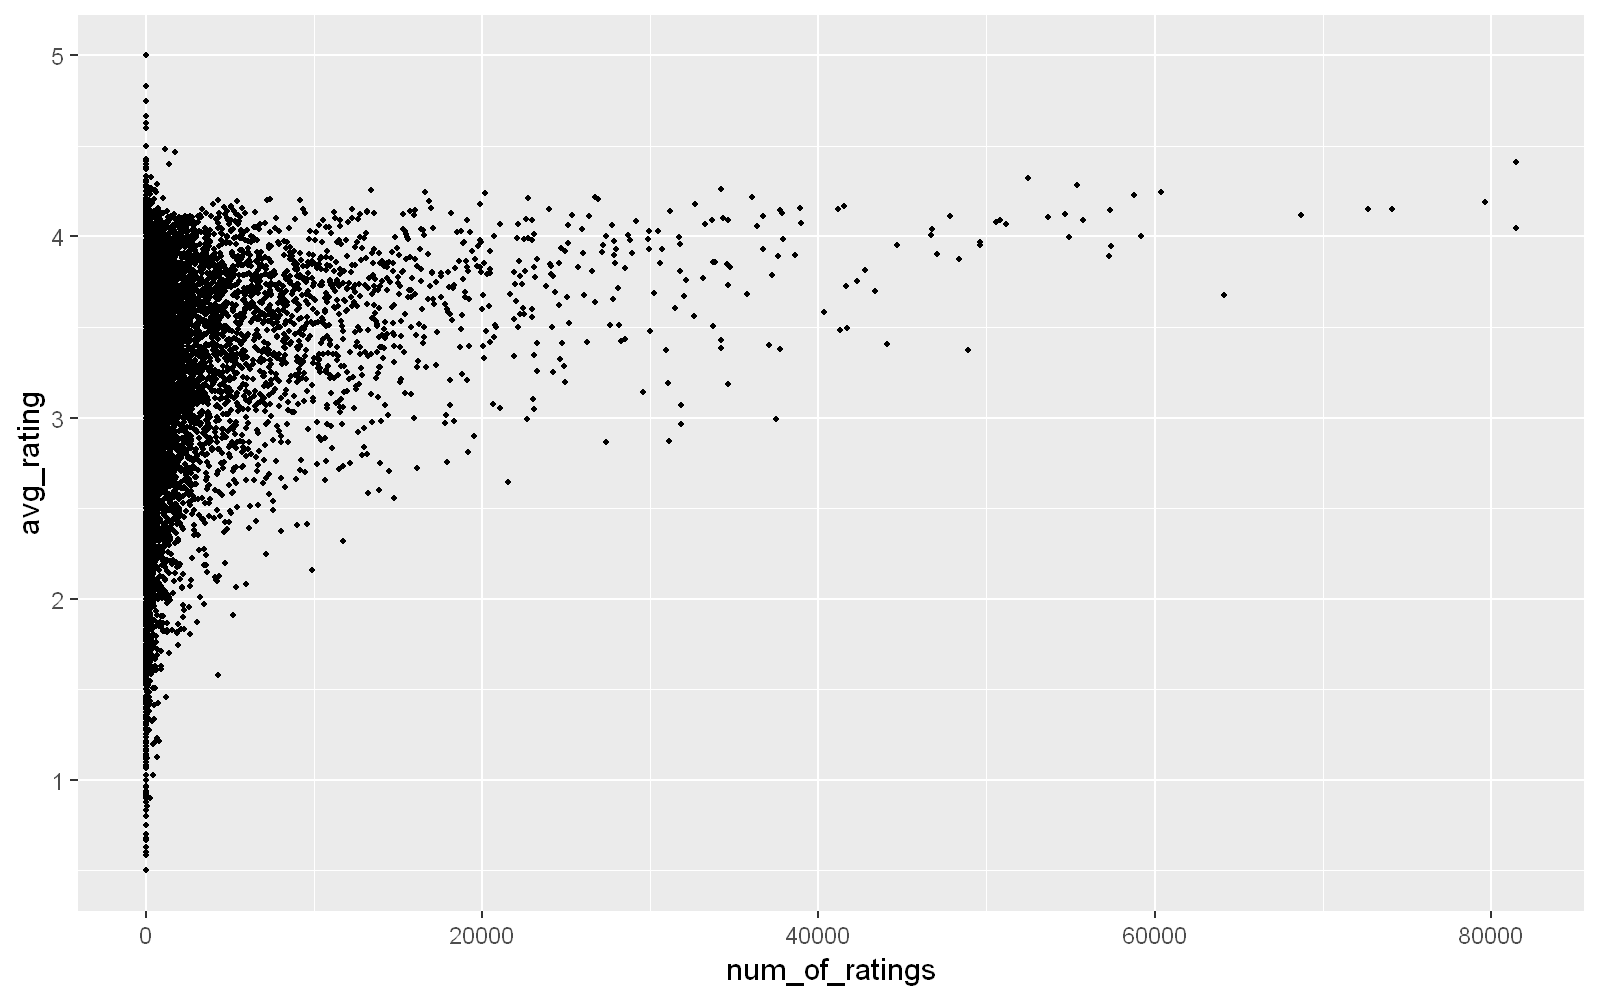

In [31]:
df_ratings %>% 
  lazy_dt() %>% 
  group_by(title) %>% 
  summarise(
    num_of_ratings = n(),
    avg_rating = mean(rating, na.rm = T)
  ) %>% 
  as_tibble() %>% # need to coerce back to tibble for ggplot
  ggplot(mapping = aes(num_of_ratings, avg_rating)) + 
  geom_point(size = 0.75) 

We notice that the variance of average rating tends to decrease as number of ratings increases. One hypothesis to explain this phenomenon might be that popular movies generally tend to also be good movies. Movies with a fewer number of ratings tend to be a mix of bad movies and niche movies, leading a the wider discrepancy in ratings.

* This implies we must be very cognizant of selection bias when it comes to ratings data.

## Movies Through The Years

In [5]:
df_ratings <- df_ratings %>% 
  lazy_dt() %>% 
  mutate(     # 2 possible extraction methods; we opt for simpler one
    year = as.numeric(substr(title, nchar(title)-4, nchar(title)-1))
    # year = as.numeric(str_extract(title, "(?<=\\()[0-9]+(?=\\))"))
  ) %>% 
  as_tibble()

Warning message in eval(jsub, SDenv, parent.frame()):
"NAs introduced by coercion"


* Note: the above code cell throws a warning message that `NA` values were introduced in the Year extraction. This likely indicates that the movie titles do not all follow the same formatting.

In [33]:
df_ratings %>% 
  lazy_dt() %>% 
  select(year, title) %>% 
  distinct() %>% 
  group_by(year) %>% 
  summarise(num_of_movies = n()) %>% 
  as_tibble() %>% 
  head(10)

year,num_of_movies
<dbl>,<int>
NA,370
6,1
201,2
1874,1
1878,1
1880,1
1883,1
1887,1
1888,4


* We see 370 movie titles resulted in failed extractions, while 3 movie titles resulted in non-sensical years.

In [34]:
# view movie titles with non-sensical years
df_ratings %>% 
  lazy_dt() %>% 
  filter(year %in% c(6, 201)) %>% 
  as_tibble()

userId,movieId,title,rating,year
<dbl>,<dbl>,<chr>,<dbl>,<dbl>
24869,172451,Irwin & Fran 2013,0.5,201
43201,175335,The Garden of Afflictions 2017,0.5,201
72315,159257,6A,3.0,6
72315,175335,The Garden of Afflictions 2017,3.5,201
84107,175335,The Garden of Afflictions 2017,1.5,201
134045,159257,6A,3.0,6


In [6]:
# view movie titles with failed year extraction
df_ratings %>% 
  lazy_dt() %>% 
  filter(is.na(year)) %>% 
  group_by(title) %>% 
  summarize(
    num_of_ratings = n(),
    avg_rating = mean(rating, na.rm = T)
  ) %>% 
  arrange(desc(num_of_ratings)) %>% 
  as_tibble() %>% head(10)

title,num_of_ratings,avg_rating
<chr>,<int>,<dbl>
Ready Player One,2441,3.574355
Moonlight,2123,3.808290
Nocturnal Animals,1716,3.746212
The Favourite,1296,3.829861
Paterson,571,3.663748
Black Mirror,456,4.256579
Cosmos,277,4.326715
The OA,226,3.581858
Cosmos: A Spacetime Odissey,191,4.188482


* The major culprit seems to be movie titles with years not in parenthesis and movie titles with no years at all. 
* All of the problematic titles seem to be from movies released in the "current" year (2018 for the purposes of the data set).

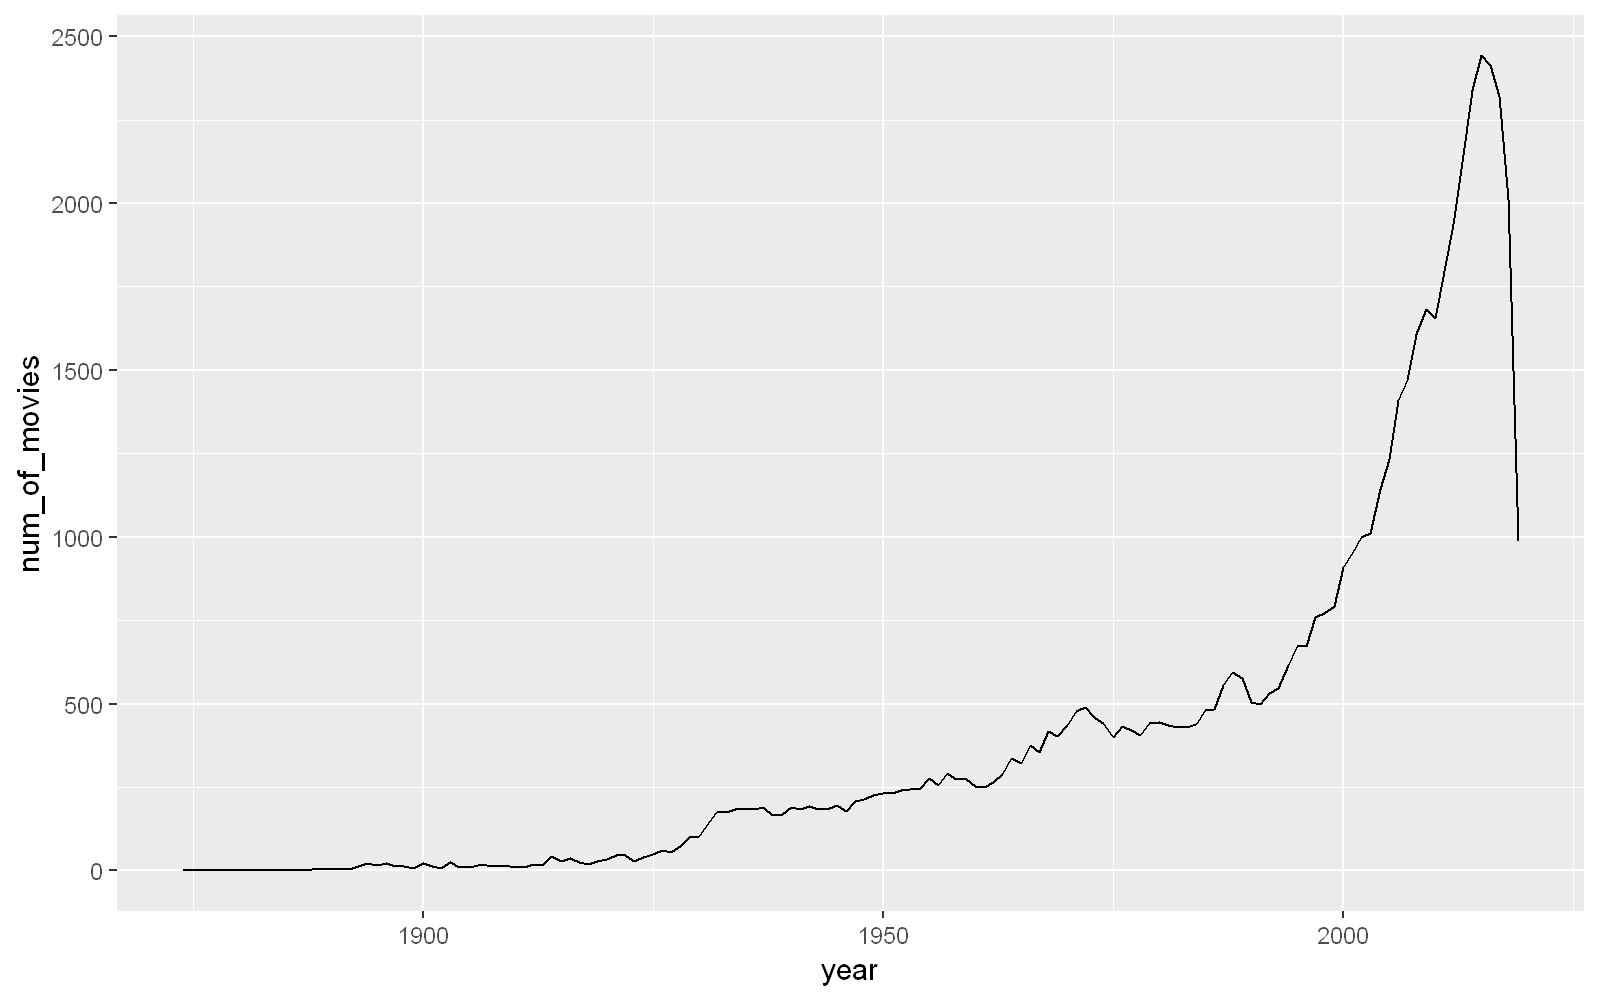

In [7]:
df_ratings %>% 
  lazy_dt() %>% 
  select(year, title) %>% 
  filter(year >= 1874) %>% 
  distinct() %>% 
  group_by(year) %>% 
  summarise(
    num_of_movies = n()
  ) %>% 
  as_tibble() %>% 
  ggplot(mapping = aes(year, num_of_movies)) + 
  geom_line()

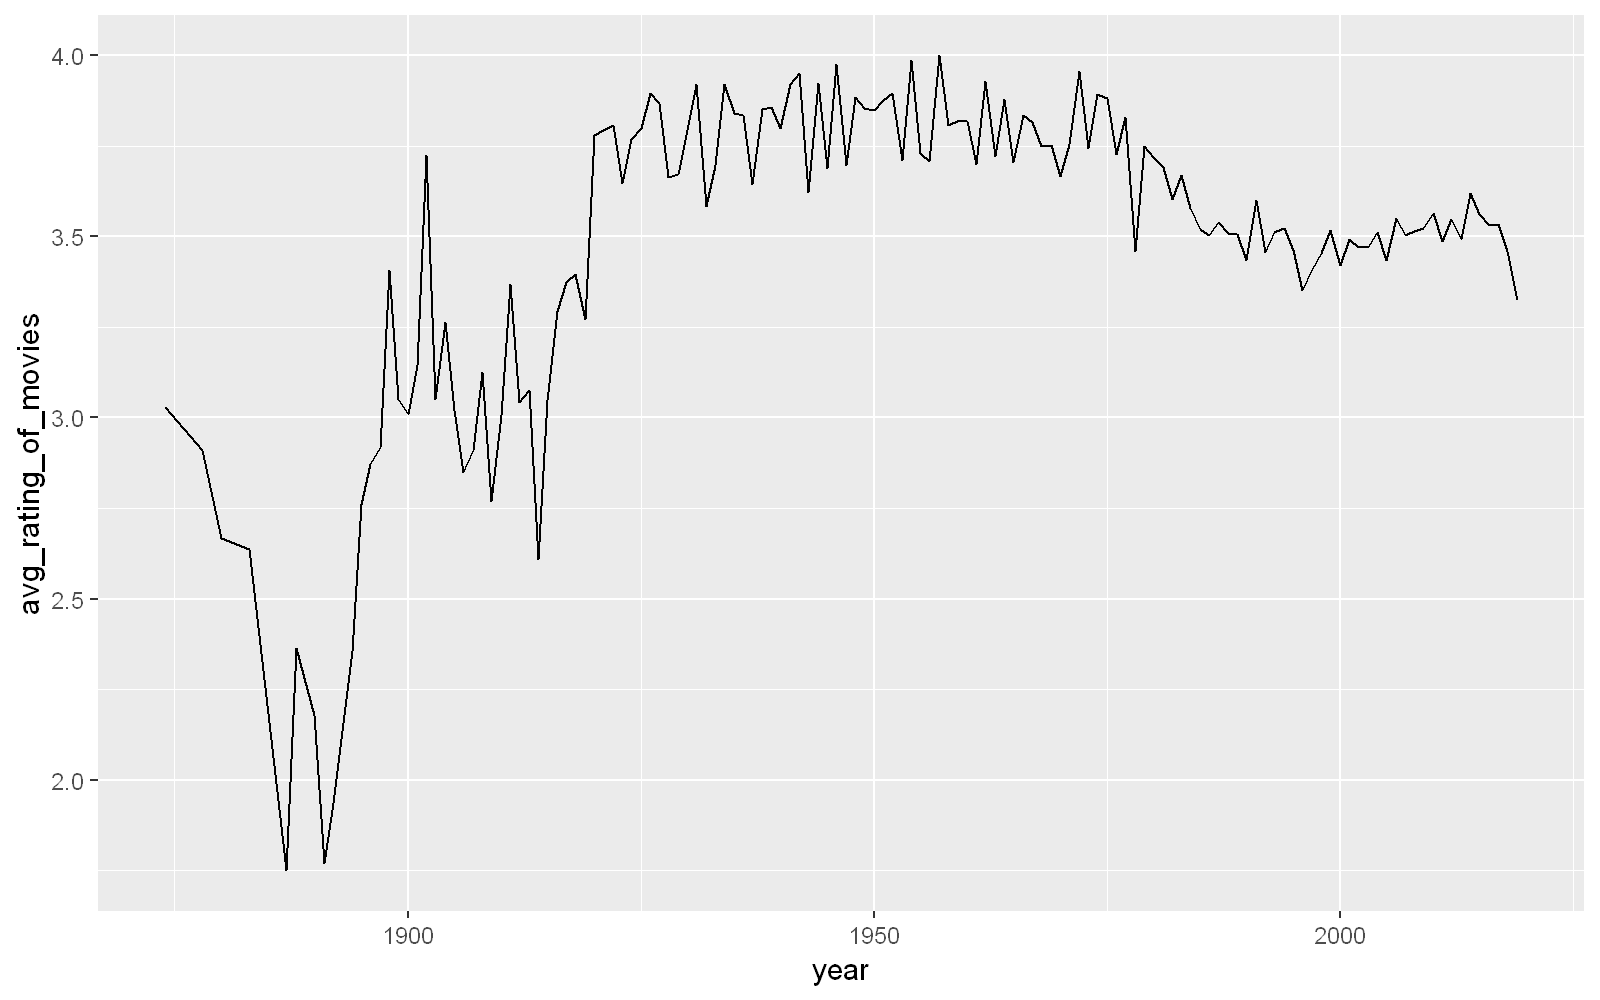

In [8]:
df_ratings %>% 
  lazy_dt() %>% 
  group_by(year) %>% 
  summarise(
    avg_rating_of_movies = mean(rating, na.rm = T)
  ) %>% 
  filter(year >= 1874) %>% 
  as_tibble() %>% 
  ggplot(mapping = aes(year, avg_rating_of_movies)) + 
  geom_line()

The number of distinct movies appearing in the data set grows exponentially by year until around 2010. One hypothesis is that advances in technology and increasing population likely drove an expansion in the film and entertainment industry. However, there are a few other considerations to think about as well:

* The underlying data generation process is contemporary: users in the 2000's are *retroactively* rating older movies. Therefore, the ratings in this data set do not necessarily reflect the public attitude for older movies during the time periods of their release.

* This also means that the movies appearing in the data set are those which have survived in people's memory. Contemporary users are much more aware of all movies released in the 2000's and 2010's, so it makes sense that a lot of the movies from this time period show up in the data set. Many of older movies have likely been forgotten and hence we don't see nearly as many older movies show up in the data set.

* The growth in movie titles really begins around 1930's, likely coinciding with the Great Depression (and later World War 2). These movies likely have historical relevance and more of these films were preserved, allowing them to survive to the modern day. Most of the films from 1870-1910's are likely forever lost to time.

Interestingly, we also see that average movie ratings by year starts trending downward starting around 1975. The likely reason is survivor bias for 1920-1975 movies: old movies need to be good or fill a niche in order for current users to actually know about them. In other words: good movies leave a lasting legacy!